In [292]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import time
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn.functional as F

# Problem 1

In [53]:
train_path = r"C:\Users\ccm51\OneDrive\Desktop\ECGR 4106\fashion-mnist_train.csv"
test_path = r"C:\Users\ccm51\OneDrive\Desktop\ECGR 4106\fashion-mnist_test.csv"
train_numpy = np.loadtxt(train_path, dtype = np.float32, delimiter = ",", skiprows=1)
test_numpy = np.loadtxt(test_path, dtype = np.float32, delimiter = ",", skiprows=1)
print(train_numpy.shape)

(60000, 785)


In [75]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i+1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [226]:
def train_model(model, total_train, total_test, loss_fn, optim, epochs, update_freq):
    train_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []

    main_tic = time.perf_counter()
    for epoch in range(1, epochs + 1):
        tic = time.perf_counter()
        loss_train = 0
        correct_train = 0
        for imgs in train_loader:
            labels = imgs[:,-1].long()
            imgs = imgs[:,:-1]

            batch_size = imgs.shape[0]
            outputs = model(imgs.view(batch_size, -1))
            _, predicted = torch.max(outputs, dim = 1)
            correct_train += int((predicted == labels).sum())
            loss = loss_fn(outputs, labels)

            optim.zero_grad()
            loss.backward()
            optim.step()

            loss_train += loss.item()

        toc = time.perf_counter()

        correct_val = 0
        with torch.no_grad():
            for imgs in val_loader:
                labels = imgs[:,-1].long()
                imgs = imgs[:,:-1]
                batch_size = imgs.shape[0]
                outputs = model(imgs.view(batch_size, -1))
                _, predicted = torch.max(outputs, dim = 1)
                correct_val += int((predicted == labels).sum())
                
        if epoch == 1 or epoch == epochs or epoch % update_freq == 0:
            print(f"Epoch {epoch}:\n\tDuration = {round(toc - tic, 3)} seconds\n\tTraining Loss: {round(loss_train / len(train_loader), 5)}\n\tTraining Accuracy: {round(correct_train/total_train, 3)}\n\tValidation Accuracy: {round(correct_val/total_val, 3)}")
        
        train_loss_hist.append(round(loss_train / len(train_loader), 5))
        train_acc_hist.append(round(correct_train/total_train, 3))
        test_acc_hist.append(round(correct_val/total_test, 3))

    main_toc = time.perf_counter()
    print(f"\nTotal Training Time = {round(main_toc - main_tic, 3)} seconds\nAverage Training Time per Epoch = {round((main_toc - main_tic) / n_epochs , 3)} seconds")
    return train_loss_hist, train_acc_hist, test_acc_hist

In [216]:
def plot_model(title, fig_num, loss_hist, train_hist, test_hist, leg_loc):
    plot = plt.figure(fig_num)
    x = range(1, len(loss_hist)+1)
    plt.plot(x, loss_hist)
    plt.plot(x, train_hist)
    plt.plot(x, test_hist)
    plt.legend(["Training Loss", "Training Accuracy", "Testing Accuracy"], loc=leg_loc)
    plt.xlabel('Epoch')
    plt.ylabel('Error/Accuracy')
    plt.title(title)

In [228]:
train_tensor = torch.from_numpy(train_numpy)
test_tensor = torch.from_numpy(test_numpy)

train_features = train_tensor[:,1:]
test_features = test_tensor[:,1:]

train_label = torch.unsqueeze(train_tensor[:,0], dim=-1)
test_label = torch.unsqueeze(test_tensor[:,0], dim=-1)

train_set = torch.cat((train_features, train_label), dim=1).to(device=try_gpu())
test_set = torch.cat((test_features, test_label), dim=1).to(device=try_gpu())

train_loader = torch.utils.data.DataLoader(train_set, batch_size=600, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_set, batch_size=test_set.shape[0], shuffle = False)

In [229]:
model_1 = nn.Sequential(
            nn.Identity(),   # Using Identity Layers as place-holders for Dropout Layers later to allow easier saving and loading of models
            nn.Linear(784, 1024),   # First Hidden Layer
            nn.ReLU(),
            nn.Identity(),
            nn.Linear(1024, 512),   # Second Hidden Layer
            nn.ReLU(),
            nn.Identity(),
            nn.Linear(512, 256),   # Third Hidden Layer
            nn.ReLU(),
            nn.Linear(256, 10)).to(device=try_gpu())   # Output Layer

optimizer_1 = optim.SGD(model_1.parameters(), lr=1e-3)

model_1.eval()

Sequential(
  (0): Identity()
  (1): Linear(in_features=784, out_features=1024, bias=True)
  (2): ReLU()
  (3): Identity()
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU()
  (6): Identity()
  (7): Linear(in_features=512, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
# class Module_1a(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(784, 1024)
#         self.act1 = nn.ReLU()
#         self.fc2 = nn.Linear(1024, 512)
#         self.act2 = nn.ReLU()
#         self.fc3 = nn.Linear(512, 256)
#         self.act3 = nn.ReLU()
#         self.fc4 = nn.Linear(256, 10)
        
#     def forward(self, x):
#         out = self.act1(self.fc1(x))
#         out = self.act2(self.fc2(out))
#         out = self.act3(self.fc3(out))
#         out = self.fc4(out)
#         return out        

In [230]:
t_loss_hist_a, t_acc_hist_a, v_acc_hist_a = train_model(model_1,
                                                        train_set.shape[0],
                                                        test_set.shape[0],
                                                        nn.CrossEntropyLoss(),
                                                        optimizer_1,
                                                        20,
                                                        5)

Epoch 1:
	Duration = 1.662 seconds
	Training Loss: 1.08243
	Training Accuracy: 0.719
	Validation Accuracy: 0.8
Epoch 5:
	Duration = 1.523 seconds
	Training Loss: 0.43935
	Training Accuracy: 0.847
	Validation Accuracy: 0.847
Epoch 10:
	Duration = 1.544 seconds
	Training Loss: 0.37876
	Training Accuracy: 0.865
	Validation Accuracy: 0.864
Epoch 15:
	Duration = 1.58 seconds
	Training Loss: 0.34601
	Training Accuracy: 0.878
	Validation Accuracy: 0.869
Epoch 20:
	Duration = 1.563 seconds
	Training Loss: 0.321
	Training Accuracy: 0.886
	Validation Accuracy: 0.871

Total Training Time = 34.137 seconds
Average Training Time per Epoch = 1.707 seconds


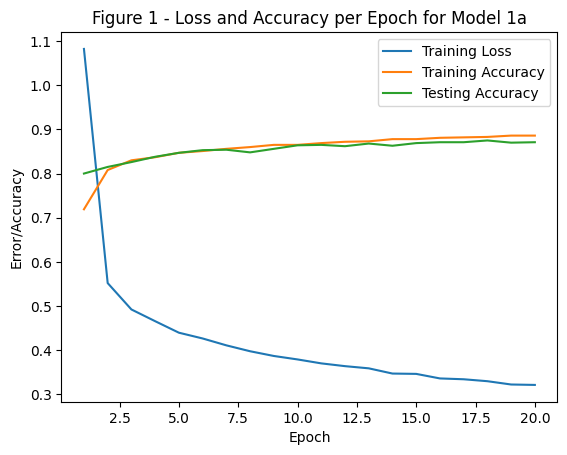

In [231]:
title_1 = "Figure 1 - Loss and Accuracy per Epoch for Model 1a"
plot_model(title_1, 1, t_loss_hist_a, t_acc_hist_a, v_acc_hist_a, 'upper right')

In [232]:
torch.save(model_1.state_dict(), "homework_0-model_1.params")

In [234]:
model_2 = nn.Sequential(
            nn.Identity(),
            nn.Linear(784, 1024),   # First Hidden Layer
            nn.ReLU(),
            nn.Identity(),
            nn.Linear(1024, 512),   # Second Hidden Layer
            nn.ReLU(),
            nn.Identity(),
            nn.Linear(512, 256),   # Third Hidden Layer
            nn.ReLU(),
            nn.Linear(256, 10)).to(device=try_gpu())   # Output Layer

optimizer_2 = optim.SGD(model_2.parameters(), lr = 1e-3, weight_decay=1e-4)

model_2.eval()

Sequential(
  (0): Identity()
  (1): Linear(in_features=784, out_features=1024, bias=True)
  (2): ReLU()
  (3): Identity()
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU()
  (6): Identity()
  (7): Linear(in_features=512, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=10, bias=True)
)

In [235]:
t_loss_hist_b, t_acc_hist_b, v_acc_hist_b = train_model(model_2,
                                                        train_set.shape[0],
                                                        test_set.shape[0],
                                                        nn.CrossEntropyLoss(),
                                                        optimizer_2,
                                                        20,
                                                        5)

Epoch 1:
	Duration = 1.694 seconds
	Training Loss: 1.06484
	Training Accuracy: 0.714
	Validation Accuracy: 0.795
Epoch 5:
	Duration = 1.852 seconds
	Training Loss: 0.44831
	Training Accuracy: 0.843
	Validation Accuracy: 0.844
Epoch 10:
	Duration = 1.772 seconds
	Training Loss: 0.3828
	Training Accuracy: 0.865
	Validation Accuracy: 0.855
Epoch 15:
	Duration = 1.693 seconds
	Training Loss: 0.34954
	Training Accuracy: 0.876
	Validation Accuracy: 0.864
Epoch 20:
	Duration = 1.829 seconds
	Training Loss: 0.32481
	Training Accuracy: 0.885
	Validation Accuracy: 0.871

Total Training Time = 37.19 seconds
Average Training Time per Epoch = 1.86 seconds


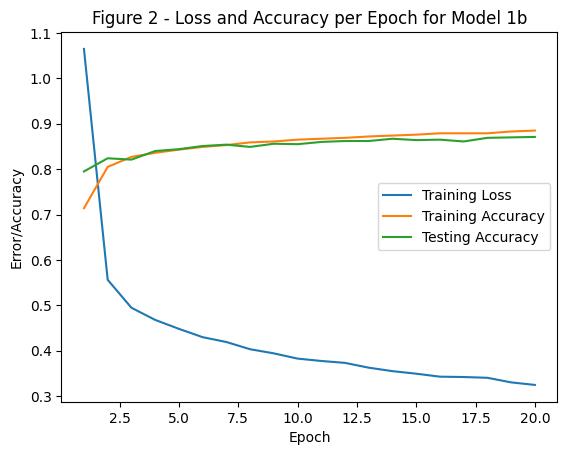

In [236]:
title_2 = "Figure 2 - Loss and Accuracy per Epoch for Model 1b"
plot_model(title_2, 2, t_loss_hist_b, t_acc_hist_b, v_acc_hist_b, 'right')

In [237]:
model_3 = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(784, 1024),   # First Hidden Layer
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(1024, 512),   # Second Hidden Layer
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 256),   # Third Hidden Layer
            nn.ReLU(),
            nn.Linear(256, 10)).to(device=try_gpu())  # Output Layer

optimizer_3 = optim.SGD(model_3.parameters(), lr = 1e-3)

model_3.eval()

Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=784, out_features=1024, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.3, inplace=False)
  (7): Linear(in_features=512, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=10, bias=True)
)

In [238]:
t_loss_hist_c, t_acc_hist_c, v_acc_hist_c = train_model(model_3,
                                                        train_set.shape[0],
                                                        test_set.shape[0],
                                                        nn.CrossEntropyLoss(),
                                                        optimizer_3,
                                                        20,
                                                        5)

Epoch 1:
	Duration = 2.05 seconds
	Training Loss: 1.23049
	Training Accuracy: 0.71
	Validation Accuracy: 0.784
Epoch 5:
	Duration = 1.537 seconds
	Training Loss: 0.44936
	Training Accuracy: 0.841
	Validation Accuracy: 0.846
Epoch 10:
	Duration = 1.564 seconds
	Training Loss: 0.38318
	Training Accuracy: 0.864
	Validation Accuracy: 0.863
Epoch 15:
	Duration = 1.516 seconds
	Training Loss: 0.34995
	Training Accuracy: 0.876
	Validation Accuracy: 0.867
Epoch 20:
	Duration = 1.525 seconds
	Training Loss: 0.32561
	Training Accuracy: 0.884
	Validation Accuracy: 0.872

Total Training Time = 34.5 seconds
Average Training Time per Epoch = 1.725 seconds


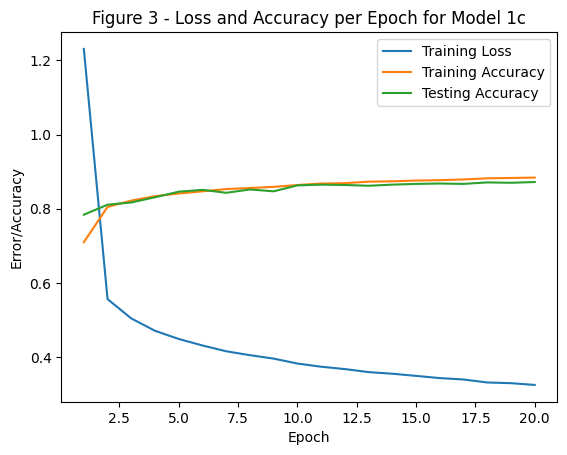

In [246]:
title_3 = "Figure 3 - Loss and Accuracy per Epoch for Model 1c"
plot_model(title_3, 3, t_loss_hist_c, t_acc_hist_c, v_acc_hist_c, 'upper right')

In [240]:
model_4 = model_2
model_4.load_state_dict(torch.load("homework_0-model_1.params"))

<All keys matched successfully>

In [241]:
t_loss_hist_d, t_acc_hist_d, v_acc_hist_d = train_model(model_4,
                                                        train_set.shape[0],
                                                        test_set.shape[0],
                                                        nn.CrossEntropyLoss(),
                                                        optimizer_2,
                                                        20,
                                                        5)

Epoch 1:
	Duration = 1.678 seconds
	Training Loss: 0.31526
	Training Accuracy: 0.888
	Validation Accuracy: 0.871
Epoch 5:
	Duration = 1.532 seconds
	Training Loss: 0.30065
	Training Accuracy: 0.894
	Validation Accuracy: 0.877
Epoch 10:
	Duration = 1.607 seconds
	Training Loss: 0.28236
	Training Accuracy: 0.9
	Validation Accuracy: 0.875
Epoch 15:
	Duration = 1.687 seconds
	Training Loss: 0.26986
	Training Accuracy: 0.903
	Validation Accuracy: 0.88
Epoch 20:
	Duration = 1.579 seconds
	Training Loss: 0.25747
	Training Accuracy: 0.91
	Validation Accuracy: 0.883

Total Training Time = 35.706 seconds
Average Training Time per Epoch = 1.785 seconds


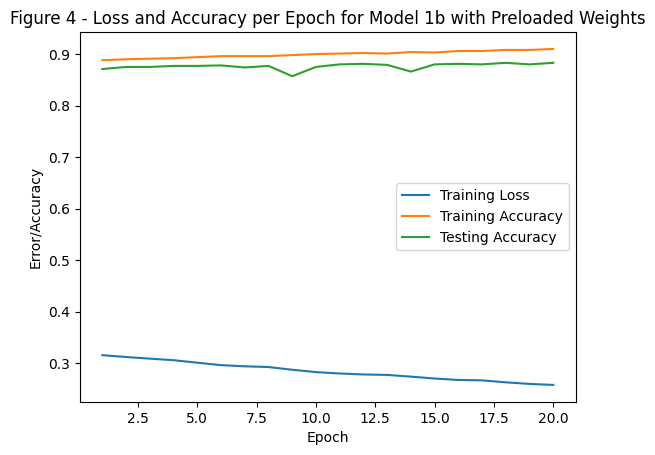

In [242]:
title_4 = "Figure 4 - Loss and Accuracy per Epoch for Model 1b with Preloaded Weights"
plot_model(title_4, 4, t_loss_hist_d, t_acc_hist_d, v_acc_hist_d, 'right')

In [243]:
model_5 = model_3
model_5.load_state_dict(torch.load("homework_0-model_1.params"))

<All keys matched successfully>

In [244]:
t_loss_hist_e, t_acc_hist_e, v_acc_hist_e = train_model(model_5,
                                                        train_set.shape[0],
                                                        test_set.shape[0],
                                                        nn.CrossEntropyLoss(),
                                                        optimizer_3,
                                                        20,
                                                        5)

Epoch 1:
	Duration = 1.554 seconds
	Training Loss: 0.31538
	Training Accuracy: 0.888
	Validation Accuracy: 0.875
Epoch 5:
	Duration = 1.441 seconds
	Training Loss: 0.29839
	Training Accuracy: 0.894
	Validation Accuracy: 0.873
Epoch 10:
	Duration = 1.567 seconds
	Training Loss: 0.28498
	Training Accuracy: 0.9
	Validation Accuracy: 0.882
Epoch 15:
	Duration = 1.555 seconds
	Training Loss: 0.2721
	Training Accuracy: 0.904
	Validation Accuracy: 0.876
Epoch 20:
	Duration = 1.506 seconds
	Training Loss: 0.25842
	Training Accuracy: 0.909
	Validation Accuracy: 0.876

Total Training Time = 34.356 seconds
Average Training Time per Epoch = 1.718 seconds


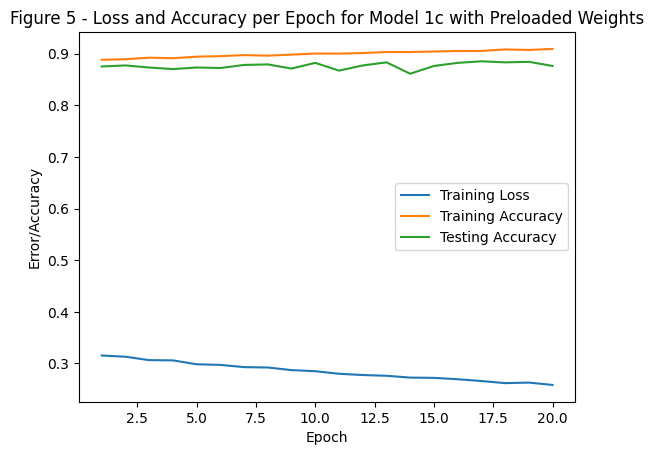

In [245]:
title_5 = "Figure 5 - Loss and Accuracy per Epoch for Model 1c with Preloaded Weights"
plot_model(title_5, 5, t_loss_hist_e, t_acc_hist_e, v_acc_hist_e, 'right')

# Problem 2

In [271]:
house_train_path = r"C:\Users\ccm51\OneDrive\Desktop\ECGR 4106\housing_train.csv"
house_test_path = r"C:\Users\ccm51\OneDrive\Desktop\ECGR 4106\housing_test.csv"
house_raw_train = pd.read_csv(house_train_path, delimiter = ",", header=0)
house_raw_test = pd.read_csv(house_test_path, delimiter = ",", header=0)

In [272]:
label = 'SalePrice'
features = pd.concat([house_raw_train.drop(columns=['Id',label]),
                     house_raw_test.drop(columns=['Id'])])

numeric_features = features.dtypes[features.dtypes != 'object'].index
features[numeric_features] = features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

features[numeric_features] = features[numeric_features].fillna(0)
features = pd.get_dummies(features, dummy_na=True)

house_train_dataframe = features[:house_raw_train.shape[0]].copy()
house_train_dataframe[label] = house_raw_train[label]
house_test_dataframe = features[house_raw_train.shape[0]:].copy()

In [544]:
def loss_1(predictions, labels):
    outputs = torch.square(torch.log10(labels) - torch.log10(torch.squeeze(predictions)))
    output = torch.sqrt(torch.mean(outputs))
    # print(predictions.shape, labels.shape, predictions, labels)
    # print(torch.squeeze(predictions).shape, outputs, output)
    return output.requires_grad_()

In [550]:
def plot_model_kfold(title, fig_num, train_loss, test_loss, leg_loc):
    plot = plt.figure(fig_num)
    x = range(1, len(train_loss)+1)
    plt.plot(x, train_loss)
    plt.plot(x, test_loss)
    plt.legend(["Training Loss", "Testing Loss"], loc=leg_loc)
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.title(title)

In [311]:
house_train_tensor = torch.tensor(house_train_dataframe.values).to(device=try_gpu()).to(torch.float32)
house_test_tensor = torch.tensor(house_test_dataframe.values).to(device=try_gpu()).to(torch.float32)

In [545]:
def train_model_kfold(model, train_tensor, batch, loss_fn, optim, epochs, update_freq, k_folds):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=0)
    main_tic = time.perf_counter()
    train_loss_hist = []
    test_loss_hist = []
    
    for epoch in range(1, epochs + 1):
        train_loss_epoch = []
        test_loss_epoch = []
        tic = time.perf_counter()
        
        for i, (train_index, test_index) in enumerate(kf.split(train_tensor)):
            train, test = train_tensor[train_index], train_tensor[test_index]
            t_loader = torch.utils.data.DataLoader(train, batch_size=batch, shuffle=True)
            v_loader = torch.utils.data.DataLoader(test, batch_size=test.shape[0], shuffle = False)
            loss_train = 0
            loss_val = 0
            
            for imgs in t_loader:
                labels = imgs[:,-1]
                imgs=imgs[:,:-1]
                batch_size = imgs.shape[0]
                outputs = model(imgs.view(batch_size, -1))
                loss_t = loss_fn(outputs, labels)
                optim.zero_grad()
                loss_t.backward()
                optim.step()
                loss_train += loss_t.item()
            
            with torch.no_grad():
                for imgs in v_loader:
                    labels = imgs[:,-1]
                    imgs = imgs[:,:-1]
                    batch_size = imgs.shape[0]
                    outputs = model(imgs.view(batch_size, -1))
                    loss_v = loss_fn(outputs, labels)
                    loss_val += loss_v.item()
                    

            train_loss_epoch.append(round(4*loss_train/len(train), 5))
            test_loss_epoch.append(round(loss_val, 5))
        
        toc = time.perf_counter()
        train_loss_hist.append(sum(train_loss_epoch)/len(train_loss_epoch))
        test_loss_hist.append(sum(test_loss_epoch)/len(test_loss_epoch))
        
        if epoch == 1 or epoch == epochs or epoch % update_freq == 0:
            print(f"Epoch {epoch}:\n\tDuration = {round(toc - tic, 3)} seconds\n\tAverage Training Loss: {round(train_loss_hist[-1], 5)}\n\tAverage Validation Loss: {round(test_loss_hist[-1], 5)}")
        
    main_toc = time.perf_counter()
    print(f"\nTotal Training Time = {round(main_toc - main_tic, 3)} seconds\nAverage Training Time per Epoch = {round((main_toc - main_tic) / n_epochs , 3)} seconds")
    return train_loss_hist, test_loss_hist


In [548]:
model_house_1 = nn.Sequential(
            nn.Identity(),
            nn.LazyLinear(512),   # First Hidden Layer
            nn.ReLU(),
            nn.Identity(),
            nn.Linear(512, 256),   # Second Hidden Layer
            nn.ReLU(),
            nn.Identity(),
            nn.Linear(256, 128),   # Third Hidden Layer
            nn.ReLU(),
            nn.Linear(128, 1)).to(device=try_gpu())  # Output Layer

optimizer_house_1 = optim.SGD(model_house_1.parameters(), lr = 1e-3)

model_house_1.eval()

Sequential(
  (0): Identity()
  (1): LazyLinear(in_features=0, out_features=512, bias=True)
  (2): ReLU()
  (3): Identity()
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Identity()
  (7): Linear(in_features=256, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=1, bias=True)
)

In [549]:
t_loss_hist_house_a, v_loss_hist_house_a = train_model_kfold(model_house_1,
                                                            house_train_tensor,
                                                            4,
                                                            loss_1,
                                                            optimizer_house_1,
                                                            20,
                                                            1,
                                                            5)

Epoch 1:
	Duration = 2.776 seconds
	Average Training Loss: 5.02613
	Average Validation Loss: 4.89212
Epoch 2:
	Duration = 2.525 seconds
	Average Training Loss: 4.14203
	Average Validation Loss: 4.08028
Epoch 3:
	Duration = 2.583 seconds
	Average Training Loss: 3.64616
	Average Validation Loss: 3.60849
Epoch 4:
	Duration = 2.533 seconds
	Average Training Loss: 3.32055
	Average Validation Loss: 3.29435
Epoch 5:
	Duration = 2.514 seconds
	Average Training Loss: 3.08113
	Average Validation Loss: 3.06126
Epoch 6:
	Duration = 2.52 seconds
	Average Training Loss: 2.89232
	Average Validation Loss: 2.87653
Epoch 7:
	Duration = 2.831 seconds
	Average Training Loss: 2.7368
	Average Validation Loss: 2.72374
Epoch 8:
	Duration = 2.695 seconds
	Average Training Loss: 2.6046
	Average Validation Loss: 2.59356
Epoch 9:
	Duration = 2.652 seconds
	Average Training Loss: 2.48965
	Average Validation Loss: 2.48022
Epoch 10:
	Duration = 2.669 seconds
	Average Training Loss: 2.38798
	Average Validation Loss: 

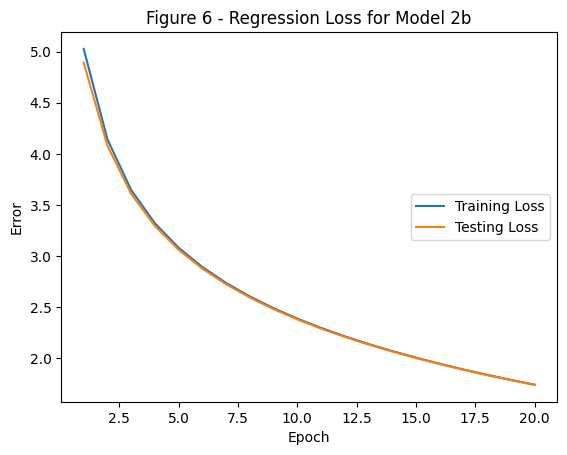

In [559]:
title_6 = "Figure 6 - Regression Loss for Model 2b"
plot_model_kfold(title_6, 6, t_loss_hist_house_a, v_loss_hist_house_a, 'right')

In [555]:
model_house_2 = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.LazyLinear(512),   # First Hidden Layer
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(512, 256),   # Second Hidden Layer
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(256, 128),   # Third Hidden Layer
            nn.ReLU(),
            nn.Linear(128, 1)).to(device=try_gpu())  # Output Layer

optimizer_house_2 = optim.SGD(model_house_2.parameters(), lr = 1e-3, weight_decay=1e-4)

model_house_2.eval()

Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): LazyLinear(in_features=0, out_features=512, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.3, inplace=False)
  (7): Linear(in_features=256, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=1, bias=True)
)

In [556]:
t_loss_hist_house_b, v_loss_hist_house_b = train_model_kfold(model_house_2,
                                                            house_train_tensor,
                                                            4,
                                                            loss_1,
                                                            optimizer_house_2,
                                                            20,
                                                            1,
                                                            5)

Epoch 1:
	Duration = 2.86 seconds
	Average Training Loss: 4.94739
	Average Validation Loss: 4.80709
Epoch 2:
	Duration = 2.836 seconds
	Average Training Loss: 4.07012
	Average Validation Loss: 4.01156
Epoch 3:
	Duration = 2.81 seconds
	Average Training Loss: 3.59933
	Average Validation Loss: 3.56339
Epoch 4:
	Duration = 3.096 seconds
	Average Training Loss: 3.28708
	Average Validation Loss: 3.26182
Epoch 5:
	Duration = 2.879 seconds
	Average Training Loss: 3.05532
	Average Validation Loss: 3.03613
Epoch 6:
	Duration = 3.168 seconds
	Average Training Loss: 2.87162
	Average Validation Loss: 2.85622
Epoch 7:
	Duration = 3.148 seconds
	Average Training Loss: 2.71951
	Average Validation Loss: 2.70683
Epoch 8:
	Duration = 2.804 seconds
	Average Training Loss: 2.58987
	Average Validation Loss: 2.57918
Epoch 9:
	Duration = 2.976 seconds
	Average Training Loss: 2.47702
	Average Validation Loss: 2.4678
Epoch 10:
	Duration = 2.938 seconds
	Average Training Loss: 2.37706
	Average Validation Loss: 

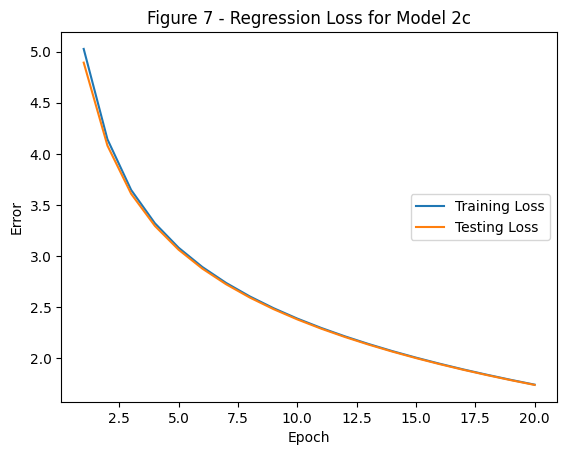

In [560]:
title_7 = "Figure 7 - Regression Loss for Model 2c"
plot_model_kfold(title_7, 7, t_loss_hist_house_a, v_loss_hist_house_a, 'right')

In [580]:
preds = model_house_2(house_test_tensor)
ensemble_preds = torch.exp(torch.squeeze(preds))
submission = pd.DataFrame({'Id':house_raw_test.Id,
                           'SalePrice':ensemble_preds.detach().cpu().numpy()})
submission.to_csv('submission.csv', index=False)

torch.Size([1459, 1])
torch.Size([1459])
